In [461]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain
import torch
import re
from collections import namedtuple

BOARD_SHAPE = (15, 19)
%matplotlib inline
plt.ioff()

Config = namedtuple('Config', ['rows', 'cols', 'letters'])

config = Config(15, 19, 'ABCDEFGHJKLMNOP')
BOARD_SHAPE = (config.rows, config.cols)

In [462]:
# Requires 1.5
torch.__version__

'1.5.0'

# Phutball PyTorch Implementation
This notebook is to develop a (not-so-simple) function that takes as input a PyTorch tensor representing the game stat, and as output returns a tensor representing the possible next states.

State representation:
    - A tensor of shape (3, 15, 19) and dtype Boolean with the last two dimensions representing the board, and the first dimension the "channels".
    - Channel 1: Whether a player is located there
    - Channel 2: Whether the ball is located there
    - Channel 3: Whether a player located there is jumpable.
    
For simplicty, the case where the ball is off the board need not be considered. If a state can be off the board **to the right only**, a special return value should be given indicated this.

The bot will always be assumed to be playing to the **right**.

## Part 1: Placement, without worrying about channel 3

## Utilities
Tools to construct and visualize the board states. Not meant to be performant.

In [463]:
NUM_CHANNELS = 2

In [464]:
class InvalidConfiguration(Exception):
  pass

In [504]:
def parseLocation(locStr):
  try:
    match = re.match(f'([{config.letters}])(\\d+)', locStr)
  except Exception as e:
    raise ValueError(f'Bad Location {locStr}') from e
  if not match:
    raise ValueError(f'Bad location {locStr}')

  row, col = match.groups()
  row = config.letters.index(row)
  col = int(col) - 1
  
  return row, col

In [466]:
def createState(ballLoc, *playerLocs):
  ballChannel   = np.zeros(BOARD_SHAPE)
  playerChannel = np.zeros(BOARD_SHAPE)
  
  for (array, locs) in [(ballChannel, [ballLoc]), (playerChannel, playerLocs)]:
    for loc in locs:
      row, col = parseLocation(loc)
      array[row][col] = 1
  return torch.tensor(np.stack([playerChannel, ballChannel]), dtype = torch.bool)

In [467]:
def visualize_state(tensor):
  plt.close() # save memory
  
  data = tensor.numpy()
  players = (data[0], 'black')
  ball    = (data[1], 'red')
  
  if (players[0] + ball[0]).max() > 1:
    raise InvalidConfiguration('Play and Ball collocated')
  elif ball[0].sum() != 1:
    raise InvalidConfiguration('Wrong number of balls')
  
  fig, ax = plt.subplots()
  ax.set_xlim([0.5  , 19.5])
  ax.set_ylim([-15.5, -0.5])
  ax.grid(True)
  ax.set_xticks(list(range(1,20)))
  ax.set_yticks(list(range(-15, 0)));
  ax.set_yticklabels('ABCDEFGHJKLMNOP'[::-1])

  for (array, color) in [players, ball]:
    for row in range(15):
      for col in range(19):
        if array[row][col]:
          ax.add_patch(plt.Circle((col+1, -(row+1)), 0.3, color=color))

  return fig

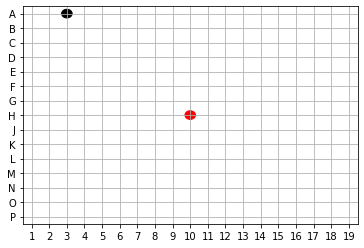

In [468]:
curr_state = createState('H10', 'A3')
visualize_state(curr_state)

## Computation of the Player Channel

In [469]:
from functools import reduce

In [470]:
# Exists in the math module in python 3.8+
def product(iterable, start = 1):
  return reduce(lambda x, y : x * y, iterable, start)

In [471]:
# Indexing goes according to the torch.flatten
#  logic, with earlier dimensions (here: row)
def get_flat_index(row, col):
  return row * config.cols + col

In [472]:
# Create an array of all possible player additions, even the illegal ones
#  Static: only has to be computed once. Performance not a concern.
placements = np.zeros(
  (product(BOARD_SHAPE), NUM_CHANNELS, *BOARD_SHAPE)
)

for row in range(config.rows):
  for col in range(config.cols):
    flat_index = get_flat_index(row, col)
    
    # Flat index is the branch for placement
    # 0 is the player channel
    placements[flat_index][0][row][col] = 1
    
placements = torch.tensor(placements, dtype = torch.bool)

In [473]:
def possible_placements(curr_state):
  '''Given a state curr_state, compute legal next states due to placing
  a piece
  
  Input: a (channels, config.rows, config.cols) bool tensor representing
         the board state
  
  Output: a (branchNum, channels, config.rows, config.cols) bool tensor
          with dim=0 indexing the possible next states and brancNum
          the number of legal moves.
  
  '''

  # Consider only the ball and player layers and sum them and invert get legal positions
  players = curr_state.select(0, 0) # view
  ball    = curr_state.select(0, 1) # view
  legal   = torch.bitwise_or(players, ball).bitwise_not_() # new tensor

  legal_indices = legal.flatten().nonzero(as_tuple=True)[0]

  new_placements = placements.index_select(0, legal_indices)
  new_states = new_placements + curr_state
  
  return new_states

### Testing

In [476]:
new_states = possible_placements(curr_state)

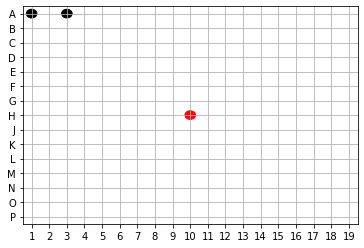

In [477]:
# First placement in upper left
visualize_state(new_states[0])

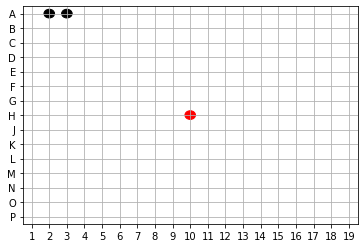

In [478]:
# Second placement moves across rows
visualize_state(new_states[1])

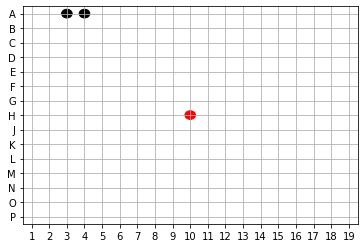

In [479]:
# Next placement skips the illegal spot
visualize_state(new_states[2])

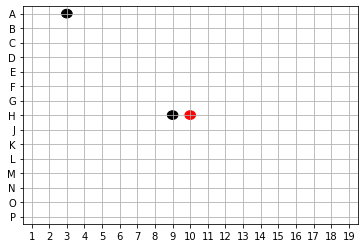

In [480]:
# Placement next to the ball
visualize_state(new_states[140])

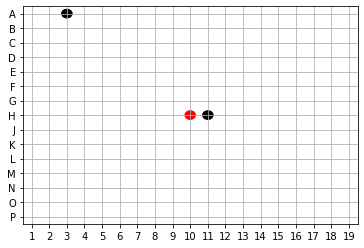

In [481]:
# Ball is skipped
visualize_state(new_states[141])

### Profiling (on CPU)

In [482]:
def lmap(func, iterable): return list(map(func, iterable))
def lfilter(predicate, iterable): return list(filter(predicate, iterable))

In [483]:
from more_itertools import unique_everseen

In [484]:
import math

In [485]:
def genLoc(n, *exclude, depth = 0):
  '''Generate n random locations not overlapping exclude'''
  
  if depth > 10:
    raise RecursionError('Unable to generate enough examples by choosing at random with replacement')
  letter_choices = list(iter(config.letters))
  
  # Create a few extra to account for exclusions
  letters = np.random.choice(letter_choices, math.floor(n * 2)).tolist()
  nums    = np.random.randint(1, 20, n + 3).tolist()
  
  locs = map(lambda tup : tup[0] + str(tup[1]), zip(letters, nums))
  locs = filter(lambda loc : loc not in exclude, locs)
  locs = list(unique_everseen(locs))
  
  if len(locs) < n:
    return genLoc(n, *exclude, depth = depth + 1)
  else:
    return locs[:n]

In [486]:
# 50 boards of varying sizes
boards = [createState('H10', *genLoc(i, 'H10')) for i in range(50)]

In [487]:
%%timeit
possible_placements(boards[0]);

110 µs ± 3.73 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [488]:
%%timeit
possible_placements(boards[-1]);

147 µs ± 84.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [489]:
# Conclusion: extremely fast. Compared to the time to compute the network, essentially 0.

# Part 2: Jumps, without worrying about channel 3

After racking my brain, I can't see any way to do this without either (a) extensive roundtrips to the CPU; or (b)
A single trip to the CPU to do the computations and return.

This is implemented in the exact same way as in /app/webserver/frontend/src/gameLogic/jump.js, but uses caches for efficience. It's also a bit more parsimonious

### Some Profiling

In [490]:
from functools import lru_cache

In [491]:
from itertools import product as cartesian_product

In [492]:
from itertools import chain

In [493]:
# List are monads
# "A monad is just a monoid in the category of endofunctors, what's the problem?"
join = chain.from_iterable

In [582]:
class Direction:
  '''Represents one of the 8 directions (horizontal, vertical,
  or 4 diagonals) based on the standard numpad 1-9. e.g.
  1 is down-left; 5 is stay pat; 8 is straight up.
  
  Coordinates are in index-coordinates (0-14 for the rows,
  and 0-18 for the columns). Compare board coordinates
  (1-15 and 1-19 respectively).
  
  Index coordinates -1 and 19 are legal but not 
  on the board.
  
  Non-performant; will be wrapped in a cache.
  '''
  def __init__(self, direction):
    self.deltaX = 0
    self.deltaY = 0
    self.code   = direction
    
    if direction in [1,4,7]:
      self.deltaX = -1
    elif direction in [3,6,9]:
      self.deltaX = +1
      
    # Note that the the y direction
    #  is reversed because the 0-index
    #  is at the top
    if direction in [1,2,3]:
      self.deltaY = +1 
    elif direction in [7,8,9]:
      self.deltaY = -1
      
  def add(self, y, x):
    outInfo = namedtuple('OutInfo', ['index', 'isLegal', 'onBoard', 'code'])
    
    outX = x + self.deltaX
    outY = y + self.deltaY
    
    if -1 <= outX <= config.cols + 1 and \
        0 <= outY < config.rows:
      legalPosition = True
    else:
      legalPosition = False
    
    if legalPosition and 0 <= outX < config.cols:
      onBoard = True
    else:
      onBoard = False
      
    return outInfo((outY, outX), legalPosition, onBoard, self.code)

In [588]:
# Wrap the above computations in a cache.
#  Compare functools.lru_cache and native python dic
@lru_cache(maxsize = 512)
def get_dests_from_rest(currPos):
  directions = map(Direction, [1,2,3,4,6,7,8,9]) #No 5
  dests = map(lambda direction : direction.add(*currPos), directions)
  dests = filter(lambda dest : dest.onBoard, dests)
  dests = map(lambda dest : dest.index, dests)
  dests = list(dests)
  return dests

get_dests_from_rest.cache_clear()

# Time it uncached
%time [get_dests_from_rest(currPos) for currPos in cartesian_product(range(config.rows), range(config.cols))]

print(get_dests_from_rest.cache_info())
print()

# Time it cached
%timeit [get_dests_from_rest(currPos) for currPos in cartesian_product(range(config.rows), range(config.cols))]
print(get_dests_from_rest.cache_info())
print()

# Compare to a python dict (these are waaay faster)
get_dests_from_rest.cache_clear()
from_rest = {}

for currPos in cartesian_product(range(config.rows), range(config.cols)):
  from_rest[currPos] = get_dests_from_rest(currPos)

%timeit [from_rest[currPos] for currPos in cartesian_product(range(config.rows), range(config.cols))]

CPU times: user 236 ms, sys: 6.54 ms, total: 243 ms
Wall time: 260 ms
CacheInfo(hits=0, misses=285, maxsize=512, currsize=285)

63.7 µs ± 1.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
CacheInfo(hits=23116635, misses=285, maxsize=512, currsize=285)

42.8 µs ± 5.27 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [591]:
# We actually want a slightly different function returning
#  (newIndex, direction)
def _get_dests_from_rest(currPos):
  directions = map(Direction, [1,2,3,4,6,7,8,9]) #No 5
  dests = map(lambda direction : direction.add(*currPos), directions)
  dests = filter(lambda dest : dest.onBoard, dests)
  dests = map(lambda dest : (dest.index, dest.code), dests)
  dests = list(dests)
  return dests

get_dests_from_rest = {}
for currPos in cartesian_product(range(config.rows), range(config.cols)):
  get_dests_from_rest[currPos] = _get_dests_from_rest(currPos)

# Only ever returns 0 or 1 return values.
#  but it is a list, hence plural
@lru_cache(maxsize = 4096)
def _get_dests_from_motion(data):
  '''Input: same type as output of 
  get_dests_from_rest
  '''
  loc, direction = data
  
  direction = Direction(direction)
  new_loc   = direction.add(*loc)
  if new_loc.isLegal:
    return [new_loc.index]
  else:
    return []

In [592]:
# Check there are the correct number of values to call
#  The number is given by inclusion-exclusion (suitably modified)
assert len(list(join(get_dests_from_rest.values()))) == (17*13*8 + ((17 + 13) * 2) * 5 + 4 * 3)

# Uncached
_get_dests_from_motion.cache_clear()
%time [_get_dests_from_motion(val) for val in join(get_dests_from_rest.values())]

print(_get_dests_from_motion.cache_info())
print()

# Cached
%timeit [_get_dests_from_motion(val) for val in join(get_dests_from_rest.values())]

print(_get_dests_from_motion.cache_info())
print()

# Build the dict
get_dest_from_motion = {}
for val in join(get_dests_from_rest.values()):
  get_dest_from_motion[val] = _get_dests_from_motion(val)
  
%timeit [get_dest_from_motion[val] for val in join(get_dests_from_rest.values())]

CPU times: user 240 ms, sys: 7.98 ms, total: 248 ms
Wall time: 284 ms
CacheInfo(hits=0, misses=2080, maxsize=4096, currsize=2080)

638 µs ± 193 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
CacheInfo(hits=16870880, misses=2080, maxsize=4096, currsize=2080)

243 µs ± 15.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### The Actual Algorithm
Recursion but without the function calls... use a queue instead

#### Algorithm

In [643]:
def build_new_state(curr_state, dest_list, new_ball_loc):
  '''Create a new numpy array representing the new new state
  
  Input
  -----
  
  curr_state: current_state a shape (numChannels, config.rows, config.cols) 
              numpy array
              
  dest_list: a list of the initial and intermediate locations of the ball
             (but not the final location, which may not be on the board)

  new_ball_loc: the final location of the ball, which should be none
                if it is not on the board
                
  Output
  ------
  
  A new numpy array of same shape as curr_state that represents the new state
  '''
  
  delta = np.zeros((NUM_CHANNELS, config.rows, config.cols))
  
  initial_ball_loc = dest_list[0]
  players_removed  = dest_list[1:]
  
  delta[1][initial_ball_loc]             = -1
  delta[0][tuple(zip(*players_removed))] = -1
  if new_ball_loc is not None:
    delta[1][new_ball_loc]               = +1
    
  return curr_state + delta

In [671]:
def get_jumps(curr_state):
  '''Given a current state in the form of a state tensor
  return data for all possible jumps.
  
  Input: State tensor of shape (num_channels, config.rows, config.cols)
  
  Output: array of jump data each of the form
    (new_state_array, jump_chain) where new_state_array is a numpy array
    and a jump chain is a list of (row, col) tuples of intermediate and final
    locations of the ball along the jump (but excluding the initial location).
    In the case where it is possible to win, the return is a singleton array,
    which should be checked for the win condition.
  
  '''
  curr_state = curr_state.numpy()
  ball_loc = tuple(np.argwhere(curr_state[1])[0])

  # Queue of states to attempt to jump from, with data:
  #  (state_array, ball_loc, jump_chain).
  to_compute_from_rest   = [(curr_state, ball_loc, [])]
  
  # Return list of jump data
  jumps                  = []

  while to_compute_from_rest:

    # Unpack the first item in the queue
    state, ball_loc, preceding_chain  = to_compute_from_rest.pop()
    
    # Compute the adjacent locations the ball may be able to jump to
    dests, directions = zip(*get_dests_from_rest[ball_loc])

    # Compute whether there is a player in each of those directions
    player_occupied   = state[0][tuple(zip(*dests))]

    # For each potential jump
    for dest, direction, player_occupied in zip(dests, directions, player_occupied):
      
      # Jump is illegal if no player is there
      if not player_occupied:
        continue

      # Set up the list of initial/intermediate locations
      #  of the ball
      dest_list = [ball_loc, dest]

      # Loop while the jump hasn't failed or terminated
      while True:
        dest = get_dest_from_motion[(dest, direction)]

        # Don't jump off the board
        if not dest:
          break
        else:
          dest = dest[0]

        # The bot always moves to the right
        #  Never jump off the left
        if dest[1] == -1:
          break

        # If the bot can jump off the right then the
        #  game is over. Raise that value up as there
        #  is no further inference step for the bot.
        #  i.e. hard-code winning
        if dest[1] == config.cols:
          new_state = build_new_state(state, dest_list, new_ball_loc = None)
          jump_data = (new_state, preceding_chain + [dest])
          return [jump_data]

        # See whether there is a player in the new location
        player_occupied = state[0, dest[0], dest[1]]
        
        # If there is, the ball can go there and keep moving
        #  so continue the loop
        if player_occupied:
          dest_list.append(dest)

        # If not, the jump terminates
        elif not player_occupied:
          new_state = build_new_state(state, dest_list, new_ball_loc = dest)
          jump_data = (new_state, preceding_chain + [dest])

          # If the jump is a winning jump,
          #  just return it as a (winning)
          #  singleton array
          if dest[0] == config.cols - 1:
            return [jump_data]
          
          # Queue the new state for potential chaining
          to_compute_from_rest.append((new_state, dest, preceding_chain + [dest]))

          # Only put the jump_data in the list of 
          #  jumps to evaluate if it doesn't make you lose
          if dest[1] != 0:
            jumps.append(jump_data)
            
          break
            
  return jumps

#### Test Cases

#### Tests 1: Simple State

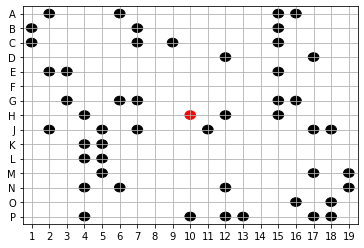

In [672]:
simple_state = boards[-1]

# Board was generated randomly. Check it
#  it usually has about 1 or 2 jumps that can be made.
visualize_state(simple_state)

In [673]:
%timeit get_jumps(simple_state)

64.3 µs ± 2.37 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


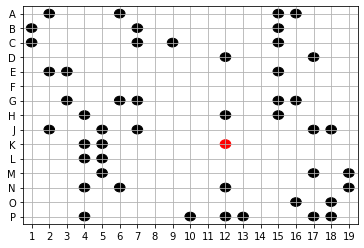

In [674]:
visualize_state(torch.tensor(get_jumps(simple_state)[0][0]))

In [675]:
test_locs = []
for let in 'ABCDEF':
  test_locs.append(f'{let}{11}')
  test_locs.append(f'{let}{9}')
for num in range(1,18):
  test_locs.append(f'G{num}')

winnable_locs = test_locs + ['G18']
winnable_locs_2 = [f'H{n}' for n in range(11,20)]

test_1           = createState('H10', *test_locs)
winnable_state   = createState('H10', *winnable_locs)
winnable_state_2 = createState('H10', *winnable_locs_2)

46541 possible jumps
1.3 s ± 80.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


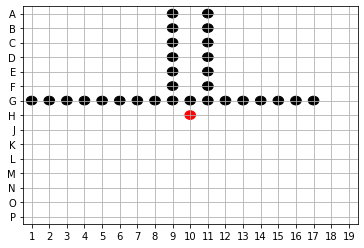

In [680]:
# Pretty fast on a per-jump basis
print(f'{len(get_jumps(test_1))} possible jumps')
%timeit get_jumps(test_1)
visualize_state(test_1)

In [688]:
final_cols = [jump_data[1][-1][1] for jump_data in get_jumps(winnable_state)]

In [689]:
list(unique_everseen(final_cols))

[7, 9, 11, 13, 15, 17, 5, 3, 1]

53065


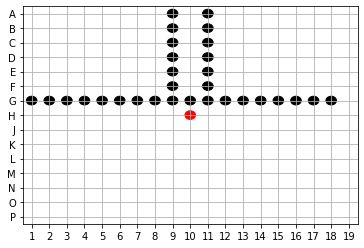

In [681]:
# Turns out this isn't actually winnable
print(len(get_jumps(winnable_state)))
visualize_state(winnable_state)

1
57.6 µs ± 1.37 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


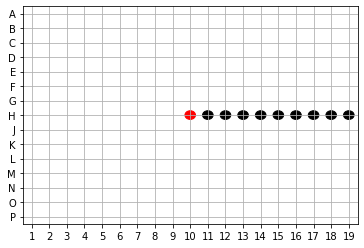

In [685]:
print(len(get_jumps(winnable_state_2)))
%timeit get_jumps(winnable_state_2)
visualize_state(winnable_state_2)